# [Tutorial 2](https://github.com/evolutionaryscale/esm/tree/main/cookbook/tutorials): Embedding with ESM C

In this notebook we will see how to embed a batch of sequences using ESM C, as well as explore its different layers

# Imports

In [1]:
# Install esm and other dependencies
! pip install esm
! pip install matplotlib

# Set up Forge client for ESM C

Grab a token from [Forge](https://forge.evolutionaryscale.ai/) and add it below. Note that your token is like a password for your account and you should take care to protect it. For this reason it is recommended to frequently create a new token and delete old, unused ones. It is also recommended to paste the token directly into an environment variable or use a utility like `getpass` as shown below so tokens are not accidentally shared or checked into code repositories.

In [2]:
from getpass import getpass

token = getpass("Token from Forge: ")

Token from Forge: ··········


In [3]:
from esm.sdk import client

model = client(
    model="esmc-300m-2024-12", url="https://forge.evolutionaryscale.ai", token=token
)

# Set up utilities for embedding sequences

Since we're embedding more than a few sequences, we're going to use a threaded async call to Forge and let Forge take care of batching and parallelization on the backend.

In [8]:
from concurrent.futures import ThreadPoolExecutor
from typing import Sequence
import time, traceback

from esm.sdk.api import (
    ESM3InferenceClient,
    ESMProtein,
    ESMProteinError,
    LogitsConfig,
    LogitsOutput,
    ProteinType,
)

EMBEDDING_CONFIG = LogitsConfig(
    sequence=True, return_embeddings=True, return_hidden_states=False
)


def embed_sequence(model: ESM3InferenceClient, sequence: str) -> LogitsOutput:
    protein = ESMProtein(sequence=sequence)
    protein_tensor = model.encode(protein)
    output = model.logits(protein_tensor, EMBEDDING_CONFIG)
    return output


def batch_embed(
    model: ESM3InferenceClient, inputs: Sequence[ProteinType]
) -> Sequence[LogitsOutput]:
    """Forge supports auto-batching. So batch_embed() is as simple as running a collection
    of embed calls in parallel using asyncio.
    """
    with ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(embed_sequence, model, protein) for protein in inputs
        ]
        results = []
        for future in futures:
            try:
                results.append(future.result())
            except Exception as e:
                results.append(ESMProteinError(500, str(e)))
    return results

def batch_embed_safe(model, seqs, batch_size=16, max_retries=6):
    outputs = []
    for i in range(0, len(seqs), batch_size):
        batch = seqs[i:i+batch_size]
        for attempt in range(max_retries):
            try:
                out = batch_embed(model, batch)
                outputs.extend(out)
                print(f"Batch {i//batch_size+1}/{(len(seqs)+batch_size-1)//batch_size} OK (+{len(out)})")
                break
            except Exception as e:
                msg = str(e).lower()
                is_rate = ("429" in msg) or ("rate" in msg and "limit" in msg) or ("too many requests" in msg)
                wait = 2 ** attempt
                print(f"Batch {i//batch_size+1} failed attempt {attempt+1}: {repr(e)}")
                if is_rate and attempt < max_retries - 1:
                    time.sleep(wait)
                    continue
                traceback.print_exc(limit=10)
                raise
    return outputs

# Requesting hidden states for the 6B model

ESM C 6B's hidden states are really large, so we offer two options:

1) Request mean-pooled hidden states. This allows you to get all layers simultaneously

2) Request one layer at a time. Refer to the model page on https://forge.evolutionaryscale.ai/ to find the number of hidden layers for each model.

If you for some reason can't assess which layer to choose and have to pick one blindly, the second to last hidden state is a good, safe choice. Often a layer earlier in the model will do a better job at your task. The second best blind guess is often 2/3'rds of the way through the model. The most principled way to make this choice is to write an evaluation for your task and train a classifier at each layer. The performance curve throughout the network will often give a clear indication which part of the network to use.

In [6]:
# Request mean-pooled hidden states
# MEAN_POOLED_EMBEDDING_CONFIG = LogitsConfig(return_hidden_states=True, return_mean_hidden_states=True)

# Request a single hidden layer at a time
# NUM_ESMC_6B_LAYERS = 80
# ONE_LAYER_EMBEDDING_CONFIG = LogitsConfig(return_hidden_states=True, ith_hidden_layer=NUM_ESMC_6B_LAYERS)

# Load dataset

This dataset is taken from Muir, et al. 2024 ["Evolutionary-Scale Enzymology Enables Biochemical Constant Prediction Across a Multi-Peaked Catalytic Landscape"](https://doi.org/10.1101/2024.10.23.619915) which explores a model enzyme called Adenylate Kinase (ADK). Adenylate Kinase appears in many different organisms with different structural classes (referred to as its "lid type"). We'll embed this set of ADK sequences and see if we can recover known structural classes.

In [9]:
from google.colab import drive

# This mounts your Google Drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/SynBio Software/competition_data/predictive-pet-zero-shot-test-2025.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


df = pd.read_csv(file_path)
df = df[["sequence", "activity_1 (μmol [TPA]/min·mg [E])", "activity_2 (μmol [TPA]/min·mg [E])", "expression (mg/mL)"]]

In [11]:

# You may see some error messages due to rate limits on each Forge account,
# but this will retry until the embedding job is complete
# This may take a few minutes to run
outputs = batch_embed_safe(model, df["sequence"].tolist(), batch_size=16)  # start small in Colab


Batch 1/312 OK (+16)
Batch 2/312 OK (+16)
Batch 3/312 OK (+16)
Batch 4/312 OK (+16)
Batch 5/312 OK (+16)
Batch 6/312 OK (+16)
Batch 7/312 OK (+16)
Batch 8/312 OK (+16)
Batch 9/312 OK (+16)
Batch 10/312 OK (+16)
Batch 11/312 OK (+16)
Batch 12/312 OK (+16)
Batch 13/312 OK (+16)
Batch 14/312 OK (+16)
Batch 15/312 OK (+16)
Batch 16/312 OK (+16)
Batch 17/312 OK (+16)
Batch 18/312 OK (+16)
Batch 19/312 OK (+16)
Batch 20/312 OK (+16)
Batch 21/312 OK (+16)
Batch 22/312 OK (+16)
Batch 23/312 OK (+16)
Batch 24/312 OK (+16)
Batch 25/312 OK (+16)
Batch 26/312 OK (+16)
Batch 27/312 OK (+16)
Batch 28/312 OK (+16)
Batch 29/312 OK (+16)
Batch 30/312 OK (+16)
Batch 31/312 OK (+16)
Batch 32/312 OK (+16)
Batch 33/312 OK (+16)
Batch 34/312 OK (+16)
Batch 35/312 OK (+16)
Batch 36/312 OK (+16)
Batch 37/312 OK (+16)
Batch 38/312 OK (+16)
Batch 39/312 OK (+16)
Batch 40/312 OK (+16)
Batch 41/312 OK (+16)
Batch 42/312 OK (+16)
Batch 43/312 OK (+16)
Batch 44/312 OK (+16)
Batch 45/312 OK (+16)
Batch 46/312 OK (+1

In [14]:
print(outputs[0])

LogitsOutput(logits=ForwardTrackData(sequence=tensor([[-35.8007, -35.8266, -35.8341,  ..., -35.7959, -35.8624, -35.8572],
        [-43.1649, -43.1598, -43.2061,  ..., -43.1190, -43.1930, -43.1654],
        [-39.2056, -39.1327, -39.1691,  ..., -39.1184, -39.1834, -39.1653],
        ...,
        [-41.5991, -41.6301, -41.6393,  ..., -41.6303, -41.6727, -41.6229],
        [-27.8606, -27.8905, -27.8226,  ..., -27.8158, -27.8916, -27.9293],
        [-31.4153, -31.3969, -31.4177,  ..., -31.3397, -31.4964, -31.5058]]), structure=None, secondary_structure=None, sasa=None, function=None), embeddings=tensor([[[ 0.0035,  0.0124, -0.0023,  ...,  0.0092,  0.0059, -0.0142],
         [-0.0154, -0.0039,  0.1079,  ...,  0.0344,  0.0623,  0.0330],
         [-0.0156,  0.0129,  0.0327,  ...,  0.0166,  0.0461,  0.0121],
         ...,
         [-0.0330,  0.0513, -0.0063,  ...,  0.0049,  0.0087,  0.0240],
         [-0.0249,  0.0513, -0.0205,  ..., -0.0140, -0.0100,  0.0054],
         [ 0.0060,  0.0664,  0.012

In [12]:
import torch

# we'll summarize the embeddings using their mean across the sequence dimension
# which allows us to compare embeddings for sequences of different lengths
all_mean_embeddings = [
    torch.mean(output.hidden_states.float(), dim=-2).squeeze() for output in outputs
]

# now we have a list of tensors of [num_layers, hidden_size]
print("embedding shape [num_layers, hidden_size]:", all_mean_embeddings[0].shape)

AttributeError: 'NoneType' object has no attribute 'float'

# Examine the performance of different layer embeddings

For this example, we're going to use PCA to visualize whether the embeddings separate our proteins by their structural class. To assess the quality of our PCA, we fit a K means classifier with three clusters, corresponding to the three structural classes of our enzyme, and compute the [rand index](https://en.wikipedia.org/wiki/Rand_index), a measure of the quality of the clustering.

In [52]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score

N_KMEANS_CLUSTERS = 3

In [20]:
def plot_embeddings_at_layer(all_mean_embeddings: torch.Tensor, layer_idx: int):
    stacked_mean_embeddings = (
        torch.stack([embedding[layer_idx, :] for embedding in all_mean_embeddings])
        .float()
        .numpy()
    )

    # project all the embeddings to 2D using PCA
    pca = PCA(n_components=2)
    pca.fit(stacked_mean_embeddings)
    projected_mean_embeddings = pca.transform(stacked_mean_embeddings)

    # compute kmeans purity as a measure of how good the clustering is
    kmeans = KMeans(n_clusters=N_KMEANS_CLUSTERS, random_state=0).fit(
        projected_mean_embeddings
    )
    rand_index = adjusted_rand_score(df["lid_type"], kmeans.labels_)

    # plot the clusters
    plt.figure(figsize=(4, 4))
    sns.scatterplot(
        x=projected_mean_embeddings[:, 0],
        y=projected_mean_embeddings[:, 1],
        hue=df["lid_type"],
    )
    plt.title(
        f"PCA of mean embeddings at layer {layer_idx}.\nRand index: {rand_index:.2f}"
    )
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.show()

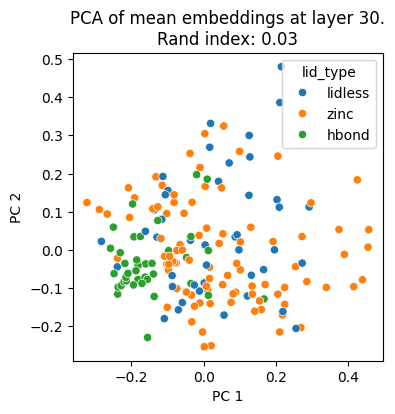

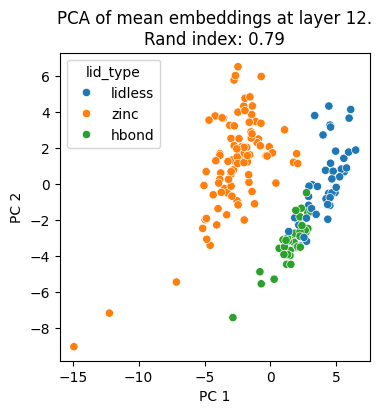

In [53]:
plot_embeddings_at_layer(all_mean_embeddings, layer_idx=30)
plot_embeddings_at_layer(all_mean_embeddings, layer_idx=12)

We see that the top principal components of layer 12 separate structural classes better than that of layer 30. Embed away! And keep in mind that different layers may be better or worse for your particular use-case.